# Explore GSM on L23

In [1]:
# imports
from importlib import reload
from importlib.resources import files
import os
import numpy as np

from scipy.optimize import curve_fit

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d

from oceancolor.hydrolight import loisel23
from oceancolor.utils import plotting as oc_plotting

from boring.models import anw as boring_anw
from boring.models import bbnw as boring_bbnw
from boring.models import utils as model_utils
from boring.models import functions
from boring import inference as big_inf
from boring import rt as big_rt
from boring import chisq_fit
from boring import plotting as boring_plotting

import anly_utils

In [2]:
%matplotlib ipympl

# Load

## L23

In [3]:
ds = loisel23.load_ds(4,0)

### Unpack

In [4]:
l23_wave = ds.Lambda.data
l23_Rrs = ds.Rrs.data
a = ds.a.data
bb = ds.bb.data
adg = ds.ag.data + ds.ad.data
aph = ds.aph.data
anw = ds.anw.data

## Fits

In [47]:
ks = [3,4,5]
k_gsm = 9
ks += [k_gsm]
#
pdict = {}
for k in ks:
    pdict[k] = {}
    # Model names
    if k == 3:
        model_names = ['Exp', 'Cst']
    elif k == 4:
        model_names = ['Exp', 'Pow']
    elif k == 5:
        model_names = ['ExpBricaud', 'Pow']
    elif k == k_gsm:  # GIOP-
        model_names = ['GSM', 'GSM']
    else:
        raise ValueError("Bad k")

    chain_file, noises, noise_lbl = anly_utils.get_chain_file(
        model_names, 0.02, False, 'L23', use_LM=True,
        PACE=True, MODIS=False)
    # Load up
    print(f'Loading {chain_file}')
    d = np.load(chain_file)
    # Parse
    pdict[k]['params'] = d['ans']
    pdict[k]['Chl'] = d['Chl']
    pdict[k]['Y'] = d['Y']
    if k == ks[0]:
        pdict['Rrs'] = d['obs_Rrs']
        pdict['idx'] = d['idx']
        pdict['wave'] = d['wave']
    #import pdb; pdb.set_trace()

Loading ../Analysis/Fits/BORING_LM_ExpCst_P23_n02.npz
Loading ../Analysis/Fits/BORING_LM_ExpPow_P23_n02.npz
Loading ../Analysis/Fits/BORING_LM_ExpBricaudPow_P23_n02.npz
Loading ../Analysis/Fits/BORING_LM_GSMGSM_P23_n02.npz


In [48]:
pdict[9]['params'].shape

(3320, 3)

# Calc a few things

## $a_{\rm ph}(440)$

In [49]:
i440_l23 = np.argmin(np.abs(l23_wave-440.))
i440_gsm = np.argmin(np.abs(pdict['wave']-440.))

In [50]:
l23_a440 = aph[:,i440_l23]
l23_Chl = (l23_a440/0.05582)
l23_a440.shape

(3320,)

## GSM

In [51]:
model_names = ['GSM', 'GSM']
#anw_model = big_anw.init_model(model_names[0], pdict['wave'])
#bbnw_model = big_bbnw.init_model(model_names[1], pdict['wave'])
#models = [anw_model, bbnw_model]
models = model_utils.init(model_names, pdict['wave'])

In [52]:
def calc_aph440(idict:dict, aph_idx:int=1):
    aph_fits = []
    for ss in range(aph.shape[0]):
        models[0].set_aph(idict['Chl'][ss])
        #
        iaph = functions.gen_basis(idict['params'][ss,aph_idx:aph_idx+1], [models[0].a_ph])
        #if ss == 1032:
        #if ss == 170:
        #j    import pdb; pdb.set_trace()
        aph_fits.append(iaph.flatten())
    #
    aph_fits = np.array(aph_fits)
    aph_fits.shape
    #
    #import pdb; pdb.set_trace()
    giop_a440 = aph_fits[:, i440_gsm]
    return giop_a440

In [53]:
gsm_a440 = calc_aph440(pdict[k_gsm])

# Plots

## $a_{\rm ph}$

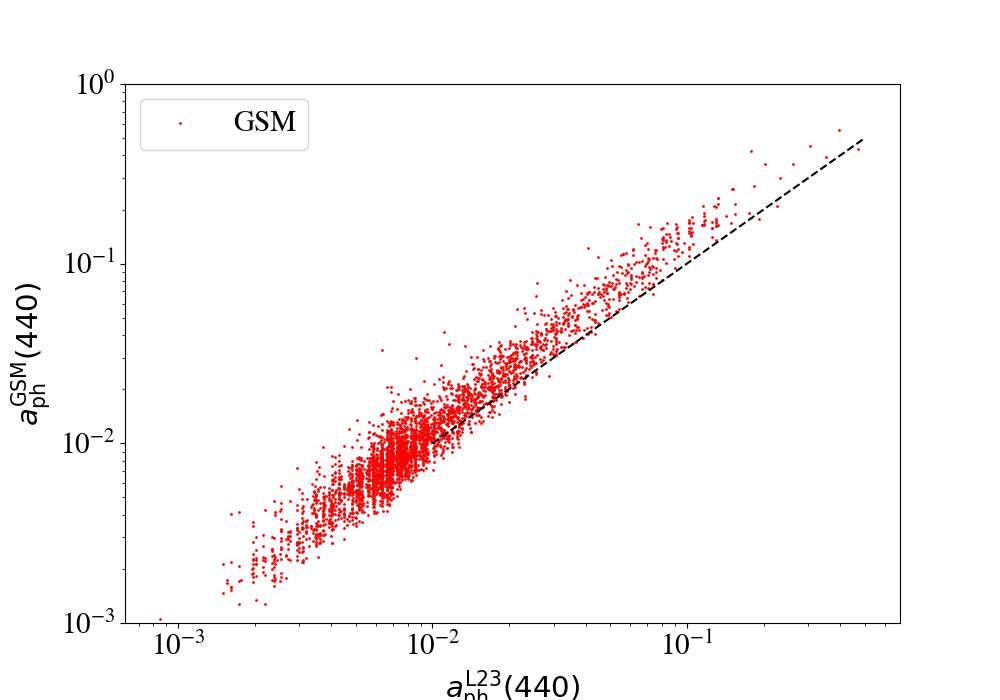

In [56]:
fig = plt.figure(figsize=(10,7))
ax = plt.gca()
#
ax.scatter(l23_a440, gsm_a440, s=1, color='r', label='GSM')
#
xmin, xmax = 0.01, 0.5
ax.plot([xmin, xmax], [xmin, xmax], 'k--')
# Log
ax.set_xscale('log')
ax.set_yscale('log')
#
ax.set_xlabel(r'$a_{\rm ph}^{\rm L23} (440)$')
ax.set_ylabel(r'$a_{\rm ph}^{\rm GSM} (440)$')
#
oc_plotting.set_fontsize(ax, 21)
ax.legend(fontsize=21.)

ax.set_ylim(1e-3, 1)
#plt.tight_layout()
plt.show()

# Chl

# Check individual fits

params=[0.01136971 0.20838089 0.00041551]


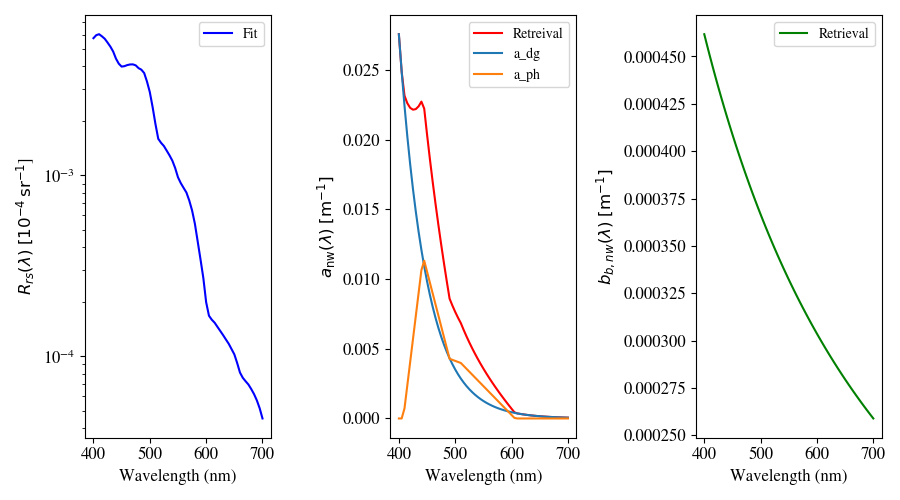

In [33]:
idx=170
params = pdict[k_gsm]['params'][idx,:]
print(f'params={10**params}')
# Set aph
models[0].set_aph(pdict[k_gsm]['Chl'][idx])
#
axes = boring_plotting.show_fit(models,  params,
    np.atleast_1d(pdict[k_gsm]['Chl'][idx]), 
    np.atleast_1d(pdict[k_gsm]['Y'][idx]),
                        figsize=(9,5)) 
# Components
slf = models[0]
a_dg = functions.exponential(slf.wave, params, pivot=slf.pivot, S=slf.Sdg)
a_ph = functions.gen_basis(params[...,1:2], [slf.a_ph])
axes[0].plot(slf.wave, a_dg.flatten(), label='a_dg')
axes[0].plot(slf.wave, a_ph.flatten(), label='a_ph')
axes[0].legend()
plt.show()

In [31]:
slf.wave

array([400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460,
       465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525,
       530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590,
       595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655,
       660, 665, 670, 675, 680, 685, 690, 695, 700])